In [70]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt

VIDEO_NUMBER = "3"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / f"recording_{VIDEO_NUMBER}" / f"Recording_{VIDEO_NUMBER}.mp4")
INPUT_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / f"Adjusted_positions_new_{VIDEO_NUMBER}.csv")

# Load video and CSV
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
if not cap.isOpened():
    raise IOError("Error: Could not open video.")
df = pd.read_csv(INPUT_CSV_PATH)
if df.empty:
    raise ValueError("Error: The CSV file is empty.")

# Select frame and next frame
frame_number = 80
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame1 = cap.read()
if not ret:
    raise IOError(f"Failed to read frame {frame_number}.")
ret, frame2 = cap.read()
if not ret:
    raise IOError(f"Failed to read frame {frame_number + 1}.")

# Extract ball center and radius
df_row1 = df.iloc[frame_number]
df_row2 = df.iloc[frame_number+1]

ball_center1 = np.array([int(df_row1['x']), int(df_row1['y'])])
ball_center2 = np.array([int(df_row2['x']), int(df_row2['y'])])
ball_radius = int(df_row1['radius'])

# Compute ROI bounds
offset = 2
x_min1 = max(ball_center1[0] - ball_radius - offset, 0)
x_max1 = min(ball_center1[0] + ball_radius + offset, frame1.shape[1])
y_min1 = max(ball_center1[1] - ball_radius - offset, 0)
y_max1 = min(ball_center1[1] + ball_radius + offset, frame1.shape[0])

x_min2 = max(ball_center2[0] - ball_radius - offset, 0)
x_max2 = min(ball_center2[0] + ball_radius + offset, frame2.shape[1])
y_min2 = max(ball_center2[1] - ball_radius - offset, 0)
y_max2 = min(ball_center2[1] + ball_radius + offset, frame2.shape[0])


# Crop ROI and convert to grayscale
roi1 = frame1[y_min1:y_max1, x_min1:x_max1]
roi2 = frame2[y_min2:y_max2, x_min2:x_max2]
gray1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(roi2, cv2.COLOR_BGR2GRAY)

# Compute center in ROI coordinates
center_roi1 = np.array([ball_center1[0] - x_min1, ball_center1[1] - y_min1])
center_roi2 = np.array([ball_center2[0] - x_min2, ball_center2[1] - y_min2])


### Feature Detection using Shi-Tomasi (Good Features to Track)

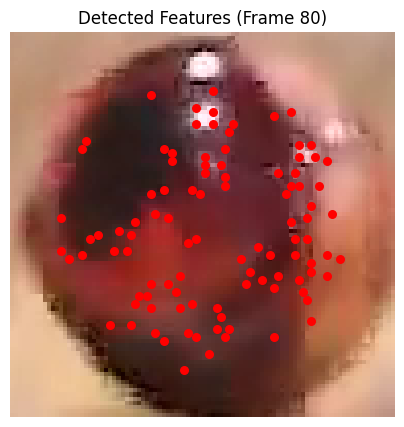

In [71]:
# Mask to focus within the ball
mask = np.zeros_like(gray1)
cv2.circle(mask, tuple(center_roi1.astype(int)), int(ball_radius * 0.8), 255, -1)

# Parameters for Shi-Tomasi
feature_params = dict(
    maxCorners=100,
    qualityLevel=0.001,
    minDistance=0,
    blockSize=3
)

# Detect corners
p0 = cv2.goodFeaturesToTrack(gray1, mask=mask, **feature_params)
if p0 is None:
    raise ValueError("No features detected. Try relaxing parameters.")

# Visualize detected features
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cv2.cvtColor(roi1, cv2.COLOR_BGR2RGB))
ax.scatter(p0[:,0,0], p0[:,0,1], s=30, c='r')
ax.set_title(f"Detected Features (Frame {frame_number})")
ax.axis('off')
plt.show()

# Track points to next frame
p1, status, _ = cv2.calcOpticalFlowPyrLK(
    gray1, gray2, p0, None,
    winSize=(15,15), maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

### Optical Flow

In [72]:
# Lift 2D points to 3D on sphere surface
old3d = []
new3d = []
for old_pt, new_pt, s in zip(p0.reshape(-1,2), p1.reshape(-1,2), status.reshape(-1)):
    if s == 1:
        ox, oy = old_pt - center_roi1
        nx, ny = new_pt - center_roi2
        oz = np.sqrt(max(ball_radius**2 - ox**2 - oy**2, 0))
        nz = np.sqrt(max(ball_radius**2 - nx**2 - ny**2, 0))
        old3d.append([ox, oy, oz])
        new3d.append([nx, ny, nz])
old3d = np.array(old3d)
new3d = np.array(new3d)

# Kabsch algorithm to find rotation matrix R
# subtract centroids (but both centered at origin already)
H = old3d.T @ new3d
U, S, Vt = np.linalg.svd(H)
R = Vt.T @ U.T
# ensure right-handed
if np.linalg.det(R) < 0:
    Vt[-1,:] *= -1
    R = Vt.T @ U.T

# extract axis-angle from R
theta = np.arccos((np.trace(R) - 1) / 2)
axis = np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]])
axis = axis / (2 * np.sin(theta))
axis = axis / np.linalg.norm(axis)


In [73]:
# Find rotation pole on ball surface
pole3d = axis * ball_radius
opp_pole3d = -axis * ball_radius

# Project to image (2D ROI coordinates, just take x and y)
pole2d = center_roi1[:2] - pole3d[:2]
opp_pole2d = center_roi1[:2] - opp_pole3d[:2]

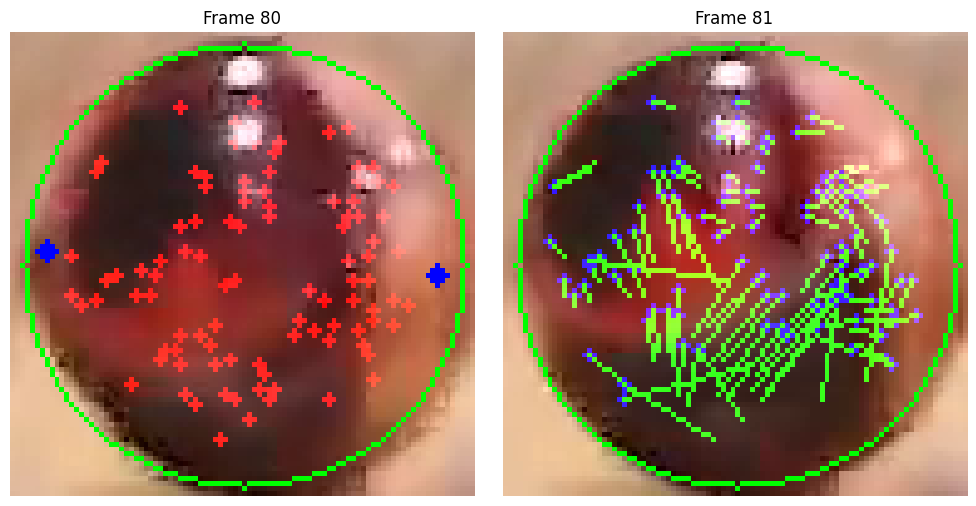

In [75]:
# prepare visualization overlay
mask = np.zeros_like(roi1)
mask2 = np.zeros_like(roi2)
# project axis to image plane (ignore z)
a2d = axis[:2]
a2d = a2d / np.linalg.norm(a2d)
# draw axis line through center_roi
length = ball_radius
pt1 = (center_roi1 + a2d * length).astype(int)
pt2 = (center_roi1 - a2d * length).astype(int)
#cv2.line(mask, tuple(pt1), tuple(pt2), (255,255,0), 2)

# draw tracked vectors
for ((new_pt,), (old_pt,), s) in zip(p1, p0, status):
    if s[0] == 1:
        c = tuple(old_pt.astype(int))
        a = tuple(new_pt.astype(int))
        cv2.circle(mask, c, 1, (0,0,255), -1)
        #cv2.circle(mask, a, 1, (255,0,0), -1)
        #cv2.line(mask, c, a, (0, 255, 0), 1)
        #cv2.circle(mask2, c, 1, (0,0,255), -1)
        cv2.circle(mask2, a, 1, (255,0,0), -1)
        cv2.line(mask2, c, a, (0, 255, 0), 1)

# overlay and display
output_roi1 = cv2.addWeighted(roi1, 1, mask, 1, 0)
output_rgb1 = cv2.cvtColor(output_roi1, cv2.COLOR_BGR2RGB)

output_roi2 = cv2.addWeighted(roi2, 1, mask2, 1, 0)
output_rgb2 = cv2.cvtColor(output_roi2, cv2.COLOR_BGR2RGB)

# show the ball center
#cv2.circle(output_rgb1, tuple(center_roi1), 1, (0, 0, 255), -1)
#cv2.circle(output_rgb2, tuple(center_roi2), 1, (0, 0, 255), -1)

# show the ball radius
cv2.circle(output_rgb1, tuple(center_roi1), ball_radius, (0, 255, 0), 1)
cv2.circle(output_rgb2, tuple(center_roi2), ball_radius, (0, 255, 0), 1)

#show rotation points
cv2.circle(output_rgb1, tuple(pole2d.astype(int)), 2, (0, 0, 255), -1)  # Yellow = rotation pole
cv2.circle(output_rgb1, tuple(opp_pole2d.astype(int)), 2, (0, 0, 255), -1)  # Magenta = opposite pole

# Display the two frames side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# First frame
axes[0].imshow(output_rgb1)
axes[0].axis('off')
axes[0].set_title(f'Frame {frame_number}')

# Second frame
axes[1].imshow(output_rgb2)
axes[1].axis('off')
axes[1].set_title(f'Frame {frame_number + 1}')

plt.tight_layout()
plt.show()

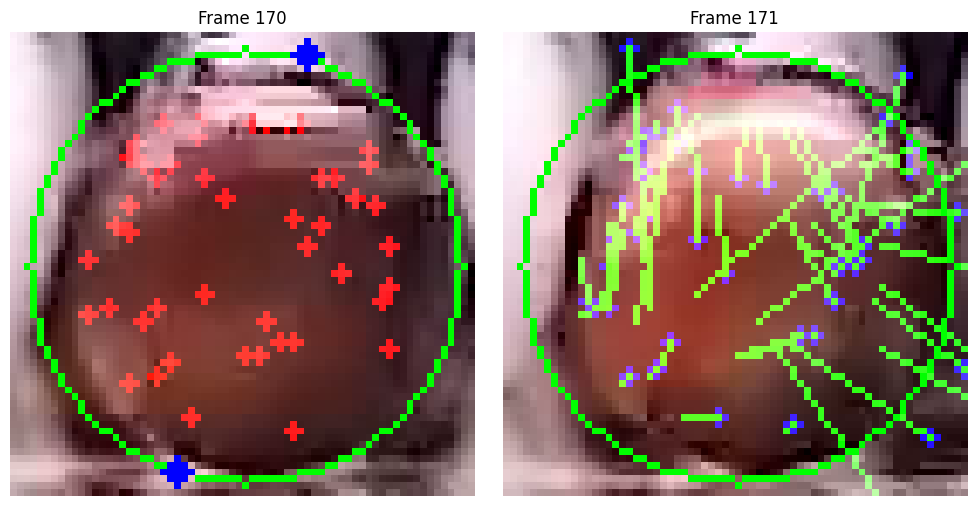

<Figure size 640x480 with 0 Axes>

In [ ]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import time
from IPython.display import clear_output, display

# --- Configurations ---
VIDEO_NUMBER = "3"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / f"recording_{VIDEO_NUMBER}" / f"Recording_{VIDEO_NUMBER}.mp4")
INPUT_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / f"Adjusted_positions_new_{VIDEO_NUMBER}.csv")

# --- Load video and CSV ---
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)

if not cap.isOpened():
    raise IOError("Error: Could not open video.")

df = pd.read_csv(INPUT_CSV_PATH)
if df.empty:
    raise ValueError("Error: The CSV file is empty.")

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
offset = 2

# --- Process frame pairs ---
for frame_number in range(frame_count - 1):

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame1 = cap.read()
    if not ret:
        print(f"Failed to read frame {frame_number}.")
        continue

    ret, frame2 = cap.read()
    if not ret:
        print(f"Failed to read frame {frame_number + 1}.")
        continue

    # --- Get CSV data for current frame pair ---
    try:
        df_row1 = df.iloc[frame_number]
        df_row2 = df.iloc[frame_number + 1]

        if df_row1[['x', 'y', 'radius']].isnull().any() or df_row2[['x', 'y', 'radius']].isnull().any():
            continue
    except IndexError:
        print(f"No CSV data for frame {frame_number}.")
        continue

    # --- Compute ball centers and ROI bounds ---
    ball_center1 = np.array([int(df_row1['x']), int(df_row1['y'])])
    ball_center2 = np.array([int(df_row2['x']), int(df_row2['y'])])
    ball_radius = int(df_row1['radius'])

    def roi_bounds(center, radius, frame_shape):
        x_min = max(center[0] - radius - offset, 0)
        x_max = min(center[0] + radius + offset, frame_shape[1])
        y_min = max(center[1] - radius - offset, 0)
        y_max = min(center[1] + radius + offset, frame_shape[0])
        return x_min, x_max, y_min, y_max

    x_min1, x_max1, y_min1, y_max1 = roi_bounds(ball_center1, ball_radius, frame1.shape)
    x_min2, x_max2, y_min2, y_max2 = roi_bounds(ball_center2, ball_radius, frame2.shape)

    roi1 = frame1[y_min1:y_max1, x_min1:x_max1]
    roi2 = frame2[y_min2:y_max2, x_min2:x_max2]
    gray1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(roi2, cv2.COLOR_BGR2GRAY)

    center_roi1 = ball_center1 - [x_min1, y_min1]
    center_roi2 = ball_center2 - [x_min2, y_min2]

    # --- Mask for feature detection ---
    mask = np.zeros_like(gray1)
    cv2.circle(mask, tuple(center_roi1.astype(int)), int(ball_radius * 0.8), 255, -1)

    feature_params = dict(
        maxCorners=100,
        qualityLevel=0.001,
        minDistance=0,
        blockSize=3
    )

    p0 = cv2.goodFeaturesToTrack(gray1, mask=mask, **feature_params)
    if p0 is None:
        raise ValueError("No features detected. Try relaxing parameters.")

    # --- Optical flow tracking ---
    p1, status, _ = cv2.calcOpticalFlowPyrLK(
        gray1, gray2, p0, None,
        winSize=(15, 15), maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    # --- Lift to 3D points ---
    old3d, new3d = [], []
    for old_pt, new_pt, s in zip(p0.reshape(-1, 2), p1.reshape(-1, 2), status.reshape(-1)):
        if s == 1:
            ox, oy = old_pt - center_roi1
            nx, ny = new_pt - center_roi2
            oz = np.sqrt(max(ball_radius**2 - ox**2 - oy**2, 0))
            nz = np.sqrt(max(ball_radius**2 - nx**2 - ny**2, 0))
            old3d.append([ox, oy, oz])
            new3d.append([nx, ny, nz])

    old3d = np.array(old3d)
    new3d = np.array(new3d)

    # --- Kabsch algorithm for rotation ---
    H = old3d.T @ new3d
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    theta = np.arccos((np.trace(R) - 1) / 2)
    axis = np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]]) / (2 * np.sin(theta))
    axis /= np.linalg.norm(axis)

    # --- Compute rotation poles ---
    pole3d = axis * ball_radius
    opp_pole3d = -pole3d

    pole2d = center_roi1[:2] - pole3d[:2]
    opp_pole2d = center_roi1[:2] - opp_pole3d[:2]

    # --- Visualization overlay ---
    mask = np.zeros_like(roi1)
    mask2 = np.zeros_like(roi2)

    for ((new_pt,), (old_pt,), s) in zip(p1, p0, status):
        if s[0] == 1:
            c = tuple(old_pt.astype(int))
            a = tuple(new_pt.astype(int))
            cv2.circle(mask, c, 1, (0, 0, 255), -1)
            cv2.circle(mask2, a, 1, (255, 0, 0), -1)
            cv2.line(mask2, c, a, (0, 255, 0), 1)

    output_roi1 = cv2.addWeighted(roi1, 1, mask, 1, 0)
    output_rgb1 = cv2.cvtColor(output_roi1, cv2.COLOR_BGR2RGB)

    output_roi2 = cv2.addWeighted(roi2, 1, mask2, 1, 0)
    output_rgb2 = cv2.cvtColor(output_roi2, cv2.COLOR_BGR2RGB)

    cv2.circle(output_rgb1, tuple(center_roi1), ball_radius, (0, 255, 0), 1)
    cv2.circle(output_rgb2, tuple(center_roi2), ball_radius, (0, 255, 0), 1)

    cv2.circle(output_rgb1, tuple(pole2d.astype(int)), 2, (0, 0, 255), -1)
    cv2.circle(output_rgb1, tuple(opp_pole2d.astype(int)), 2, (0, 0, 255), -1)

    # --- Display results ---
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(output_rgb1)
    axes[0].axis('off')
    axes[0].set_title(f'Frame {frame_number}')
    axes[1].imshow(output_rgb2)
    axes[1].axis('off')
    axes[1].set_title(f'Frame {frame_number + 1}')
    plt.tight_layout()
    plt.show()
    display(plt.gcf())
    plt.close()
    time.sleep(1 / fps)
